In [1]:
from skimage import io
import numpy as np
import os
import scanpy as sc
import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import os
import gzip
import numpy as np
import celltypist
from celltypist import models


plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
def calcQCmat(andata):
    andata.var_names_make_unique()
    andata.var["mt"] = andata.var_names.str.startswith("mt-")
    andata.var["ribo"] = andata.var_names.str.startswith(("RPS", "RPL"))
    andata.var["hb"] = andata.var_names.str.contains("^HB[^(P)]")
    sc.pp.calculate_qc_metrics(andata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
    return andata
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_016um"
andata016_ = sc.read_visium(path=path_016)
andata016 = calcQCmat(andata016_)
print(f"{np.shape(andata016.X.todense())}")
sc.pp.filter_cells(andata016, min_counts = 50)
sc.pp.filter_cells(andata016, min_genes = 80)

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy/lib/python3.10/site-packages/scanpy/readwrite.py:476: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(


(98917, 19059)


Text(0.5, 1.1, 'Number of Cells with Detected Gene Expression')

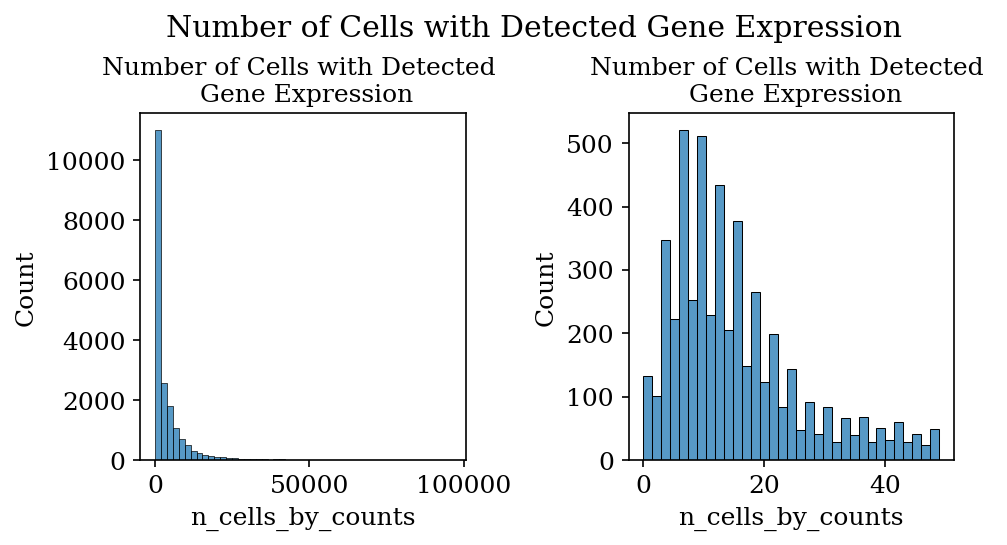

In [3]:
plt.rcParams['font.size'] = 12
fig, axs = plt.subplots(1, 2, figsize=(7, 3))  # Adjusted figsize for better readability
axs[0].set_title('Number of Cells with Detected \n Gene Expression')
axs[1].set_title('Number of Cells with Detected \n Gene Expression')
sns.histplot(andata016.var['n_cells_by_counts'], kde=False, ax=axs[0],bins = 50)
sns.histplot(andata016.var['n_cells_by_counts'][andata016.var['n_cells_by_counts'] < 50], kde=False, ax=axs[1])
plt.subplots_adjust(wspace=0.5)
plt.suptitle("Number of Cells with Detected Gene Expression", y=1.10)

In [4]:
andata016 = andata016[:,andata016.var.n_cells_by_counts > 50]
print(f'{andata016}')

View of AnnData object with n_obs × n_vars = 98697 × 13964
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'


In [5]:
print(f"{np.shape(andata016.X.todense())}")
andata016 = andata016[andata016.obs["pct_counts_mt"] < 20]
print(f"{np.shape(andata016.X.todense())}")

(98697, 13964)
(97163, 13964)


In [6]:
sc.pp.normalize_total(andata016)
sc.pp.log1p(andata016)
log1p_data = andata016.X.todense()
sc.pp.highly_variable_genes(andata016)
sc.pp.scale(andata016)
andata016.obsm['spatial'] = np.array(andata016.obsm['spatial'], dtype=np.float64)
sc.pp.pca(andata016, n_comps=10)
sc.pp.neighbors(andata016)
sc.tl.umap(andata016)
sc.tl.leiden(andata016, key_added="clusters", flavor="igraph", directed=False, n_iterations=2)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


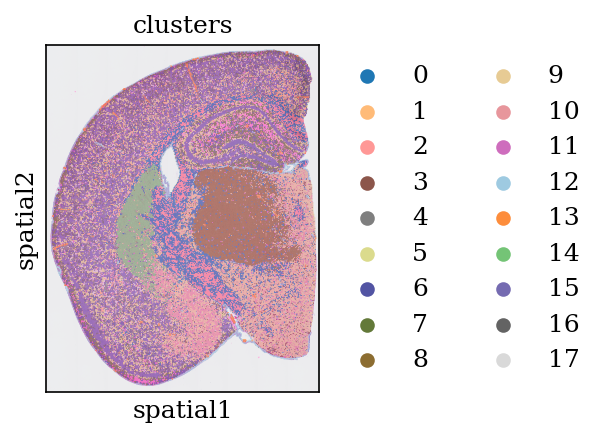

In [23]:
from matplotlib.colors import ListedColormap

# Combine multiple palettes to create a larger custom palette
palette = sns.color_palette("tab20") + sns.color_palette("tab20b") + sns.color_palette("tab20c")

# Convert the combined palette to a ListedColormap
listed_cmap = ListedColormap(palette)

# Create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot the spatial scatter plot on the specified axis
sq.pl.spatial_scatter(andata016, color="clusters", ax=ax, palette=listed_cmap)

# From cluster differentially expressed genes to cluster annotation

In [7]:
sc.tl.rank_genes_groups(
    andata016, groupby="clusters", method="wilcoxon", key_added="dea_clusters"
)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


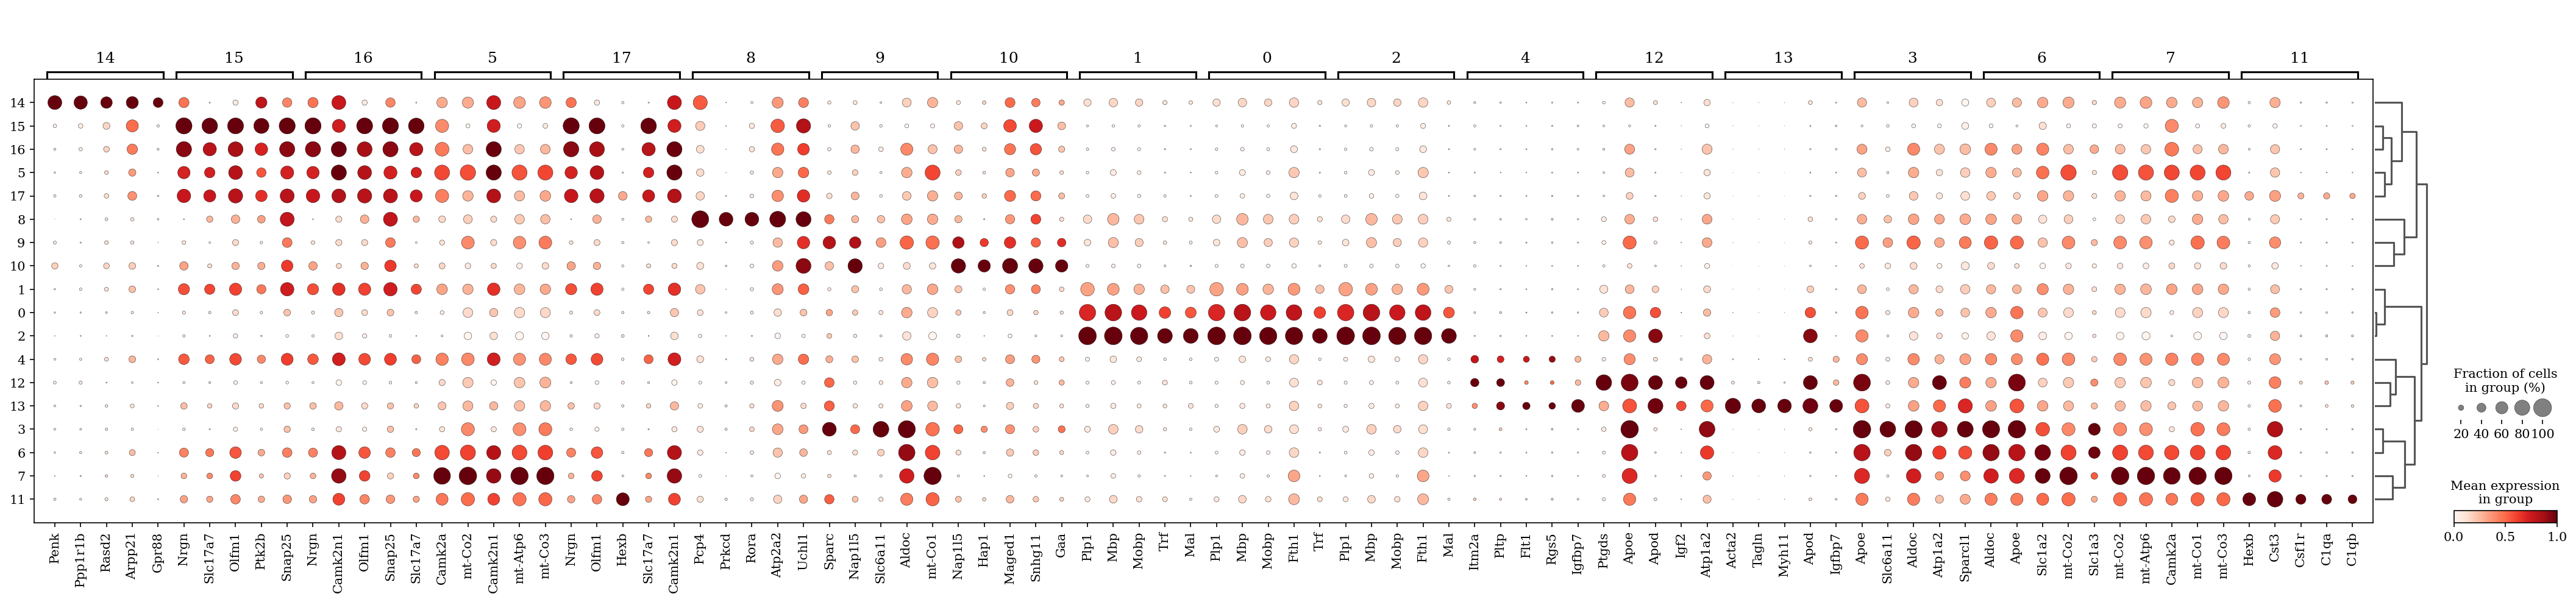

In [8]:
sc.pl.rank_genes_groups_dotplot(
    andata016, groupby="clusters", standard_scale="var", n_genes=5, key="dea_clusters"
)

## Refining Differential Gene Expression Analysis with Filter Parameters 

In Scanpy, the sc.tl.filter_rank_genes_groups function is used to filter the results of differential expression analysis. The parameters min_in_group_fraction and max_out_group_fraction help refine the selection of marker genes based on their expression patterns across groups.

Here's what these parameters mean:

min_in_group_fraction: This parameter specifies the minimum fraction of cells within a group (cluster) that must express a gene for it to be considered as a marker gene for that group. For example, if min_in_group_fraction=0.2, it means that at least 20% of the cells in the group must express the gene for it to be considered.

max_out_group_fraction: This parameter specifies the maximum fraction of cells outside the group that can express the gene for it to be considered a marker gene. For example, if max_out_group_fraction=0.2, it means that no more than 20% of the cells outside the group can express the gene for it to be considered specific to the group.

Here’s how you might explain this in your presentation:

"Refining Differential Gene Expression Analysis with Filter Parameters"

When performing differential gene expression analysis, we can apply additional filters to refine our selection of marker genes:

min_in_group_fraction: Ensures that a gene is expressed in a minimum fraction of cells within the target cluster (e.g., at least 20%).
max_out_group_fraction: Limits the fraction of cells outside the target cluster that can express the gene (e.g., no more than 20%).
This approach helps in identifying more specific and relevant marker genes for each cluster, leading to more accurate biological insights.

In [75]:
sc.tl.filter_rank_genes_groups(
    andata016,
    min_in_group_fraction=0.01,
    max_out_group_fraction=0.01,
    key="dea_clusters",
    key_added="dea_clusters_filtered",
)

In [81]:
andata016.uns['dea_clusters']['logfoldchanges']

rec.array([(nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
           (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
           (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
           ...,
           (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
           (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
           (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan)],
          dtype=[('0', '<f4'), ('1', '<f4'), ('2', '<f4'), ('3', '<f4'), ('4', '<f4'), ('5', '<f4'), ('6', '<f4'), ('7', '<f4'), ('8', '<f4'), ('9', '<f4'), ('10', '<f4'), ('11', '<f4'), ('12', '<f4'), ('13', '<f4'), ('14', '<f4'), ('15', '<f4'), ('16', '<f4'), ('17', '<f4')])

categories: 0, 1, 2, etc.
var_group_labels: 


ValueError: 'vertices' must be 2D with shape (N, 2), but your input has shape (0,)

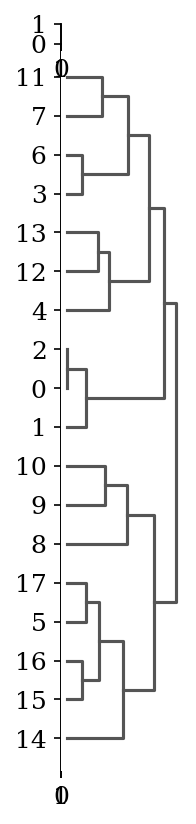

In [72]:
# Visualize the filtered genes:
sc.pl.rank_genes_groups_dotplot(
    andata016,
    groupby="clusters",
    standard_scale="var",
    n_genes=5,
    key="dea_clusters_filtered",
)

## Optimizing Cluster Granularity 

To reduce the number of clusters in your Leiden clustering results, you can adjust the resolution parameter in the sc.tl.leiden function. The resolution parameter controls the granularity of the clustering: higher values lead to more clusters, and lower values lead to fewer clusters.

ou can experiment with different values of the resolution parameter to find the optimal number of clusters for your analysis. For example, you might try resolution=0.1 for fewer clusters or resolution=1.0 for more clusters. Adjust the resolution until you achieve a satisfactory number of clusters.

In [9]:
from matplotlib.colors import ListedColormap

# Combine multiple palettes to create a larger custom palette
palette = sns.color_palette("tab20") + sns.color_palette("tab20b") + sns.color_palette("tab20c")

# Convert the combined palette to a ListedColormap
listed_cmap = ListedColormap(palette)


Text(0.5, 1.0, 'Leiden Clustering (resolution=0.1)')

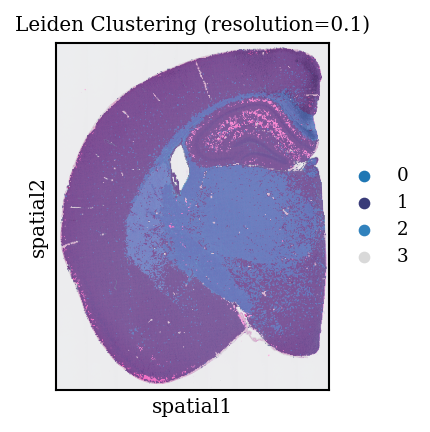

In [15]:
sns.set_context("paper", font_scale=1)

resolutions = [0.1, 0.5, 1.0, 2.0]

res = resolutions[0]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

sc.tl.leiden(andata016, key_added=f'clusters_res_{res}', flavor="igraph", directed=False, resolution=res, n_iterations=2)
sq.pl.spatial_scatter(andata016, color=f'clusters_res_{res}', ax=ax, palette=listed_cmap)
ax.set_title(f'Leiden Clustering (resolution={res})')


Text(0.5, 1.0, 'Leiden Clustering (resolution=0.5)')

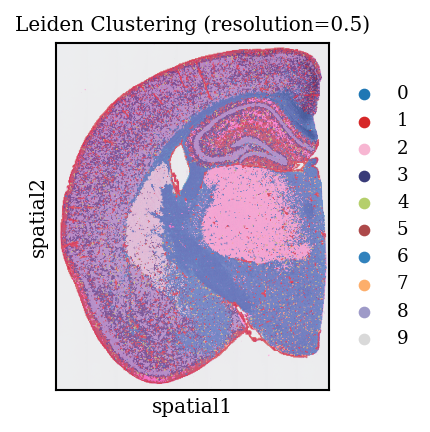

In [17]:
sns.set_context("paper", font_scale=1)

resolutions = [0.1, 0.5, 1.0, 2.0]

res = resolutions[1]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

sc.tl.leiden(andata016, key_added=f'clusters_res_{res}', flavor="igraph", directed=False, resolution=res, n_iterations=2)
sq.pl.spatial_scatter(andata016, color=f'clusters_res_{res}', ax=ax, palette=listed_cmap)
ax.set_title(f'Leiden Clustering (resolution={res})')


Text(0.5, 1.0, 'Leiden Clustering (resolution=1.0)')

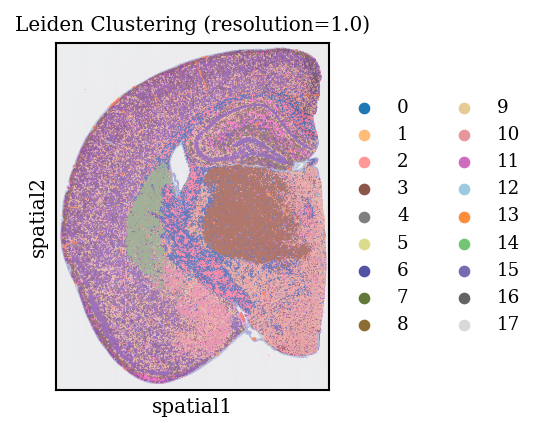

In [18]:
sns.set_context("paper", font_scale=1)

resolutions = [0.1, 0.5, 1.0, 2.0]

res = resolutions[2]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

sc.tl.leiden(andata016, key_added=f'clusters_res_{res}', flavor="igraph", directed=False, resolution=res, n_iterations=2)
sq.pl.spatial_scatter(andata016, color=f'clusters_res_{res}', ax=ax, palette=listed_cmap)
ax.set_title(f'Leiden Clustering (resolution={res})')

The selected leiden resolution would be  resolutions = 0.5.

Text(0.5, 1.0, 'Leiden Clustering (resolution=0.5)')

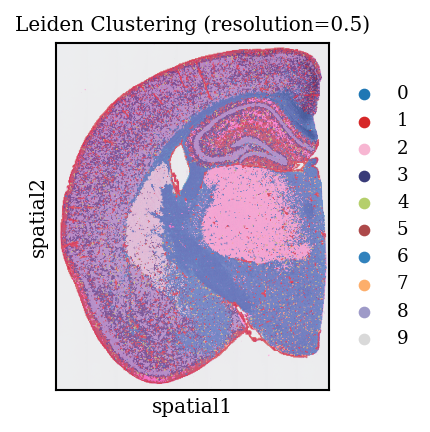

In [63]:
sns.set_context("paper", font_scale=1)

resolutions = [0.1, 0.5, 1.0, 2.0]

res = resolutions[1]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

sc.tl.leiden(andata016, key_added=f'clusters_res_{res}', flavor="igraph", directed=False, resolution=res, n_iterations=2)
sq.pl.spatial_scatter(andata016, color=f'clusters_res_{res}', ax=ax, palette=listed_cmap)
ax.set_title(f'Leiden Clustering (resolution={res})')


to incorporate spatial information into your clustering analysis in Squidpy and test different parameters for building spatial neighbors, you can use the sq.gr.spatial_neighbors function. This will allow you to leverage spatial proximity in addition to gene expression data.



categories: 0, 1, 2, etc.
var_group_labels: 0, 1, 2, etc.


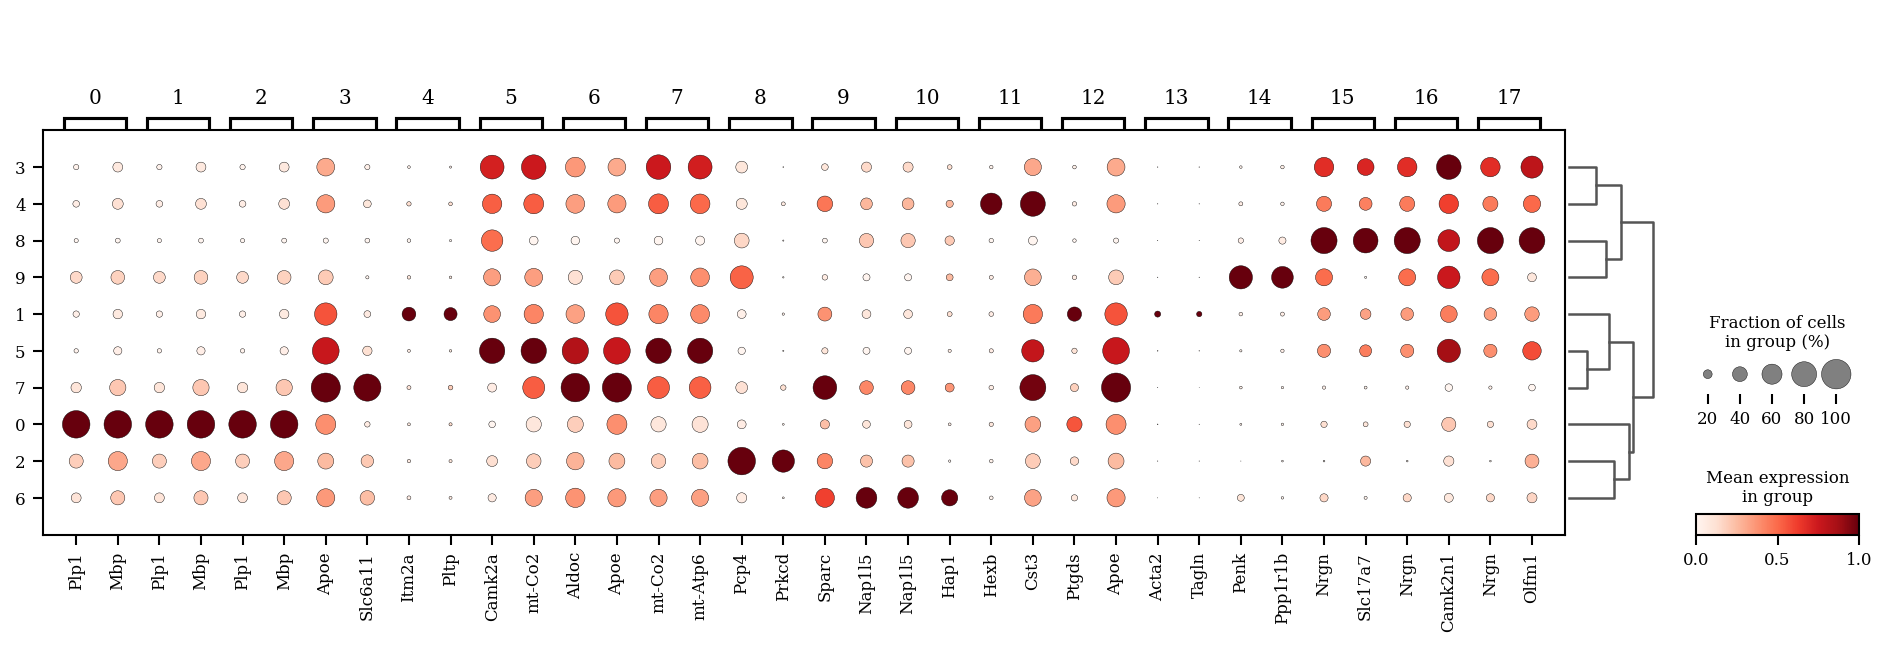

In [67]:
sc.pl.rank_genes_groups_dotplot(
    andata016, groupby="clusters_res_0.5", standard_scale="var", n_genes=2, key="dea_clusters"
)

In [54]:
andata016.obsm['spatial']

array([[16260.59518958,  3180.92420629],
       [ 5484.20259969,  9069.61407884],
       [10909.35300404,  8636.42270168],
       ...,
       [ 9764.50050473,  2404.586237  ],
       [ 1917.61394746,  8773.68001556],
       [14850.17609042, 10445.22808027]])

In [55]:
sq.gr.spatial_neighbors(andata016,coord_type="grid", key_added='spatial_neighbors')

In [61]:
andata016.obs['clusters_spatial']

s_016um_00052_00082-1     87
s_016um_00150_00268-1    108
s_016um_00144_00175-1    197
s_016um_00165_00109-1     48
s_016um_00297_00147-1    105
                        ... 
s_016um_00109_00223-1    170
s_016um_00039_00175-1     54
s_016um_00037_00193-1     38
s_016um_00144_00329-1     34
s_016um_00176_00108-1     48
Name: clusters_spatial, Length: 97163, dtype: category
Categories (265, object): ['0', '1', '2', '3', ..., '261', '262', '263', '264']

In [44]:
sc.tl.leiden(andata016, key_added=f'clusters_spatial', neighbors_key=andata016.obsp['spatial_neighbors_connectivities'])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Text(0.5, 1.0, '')

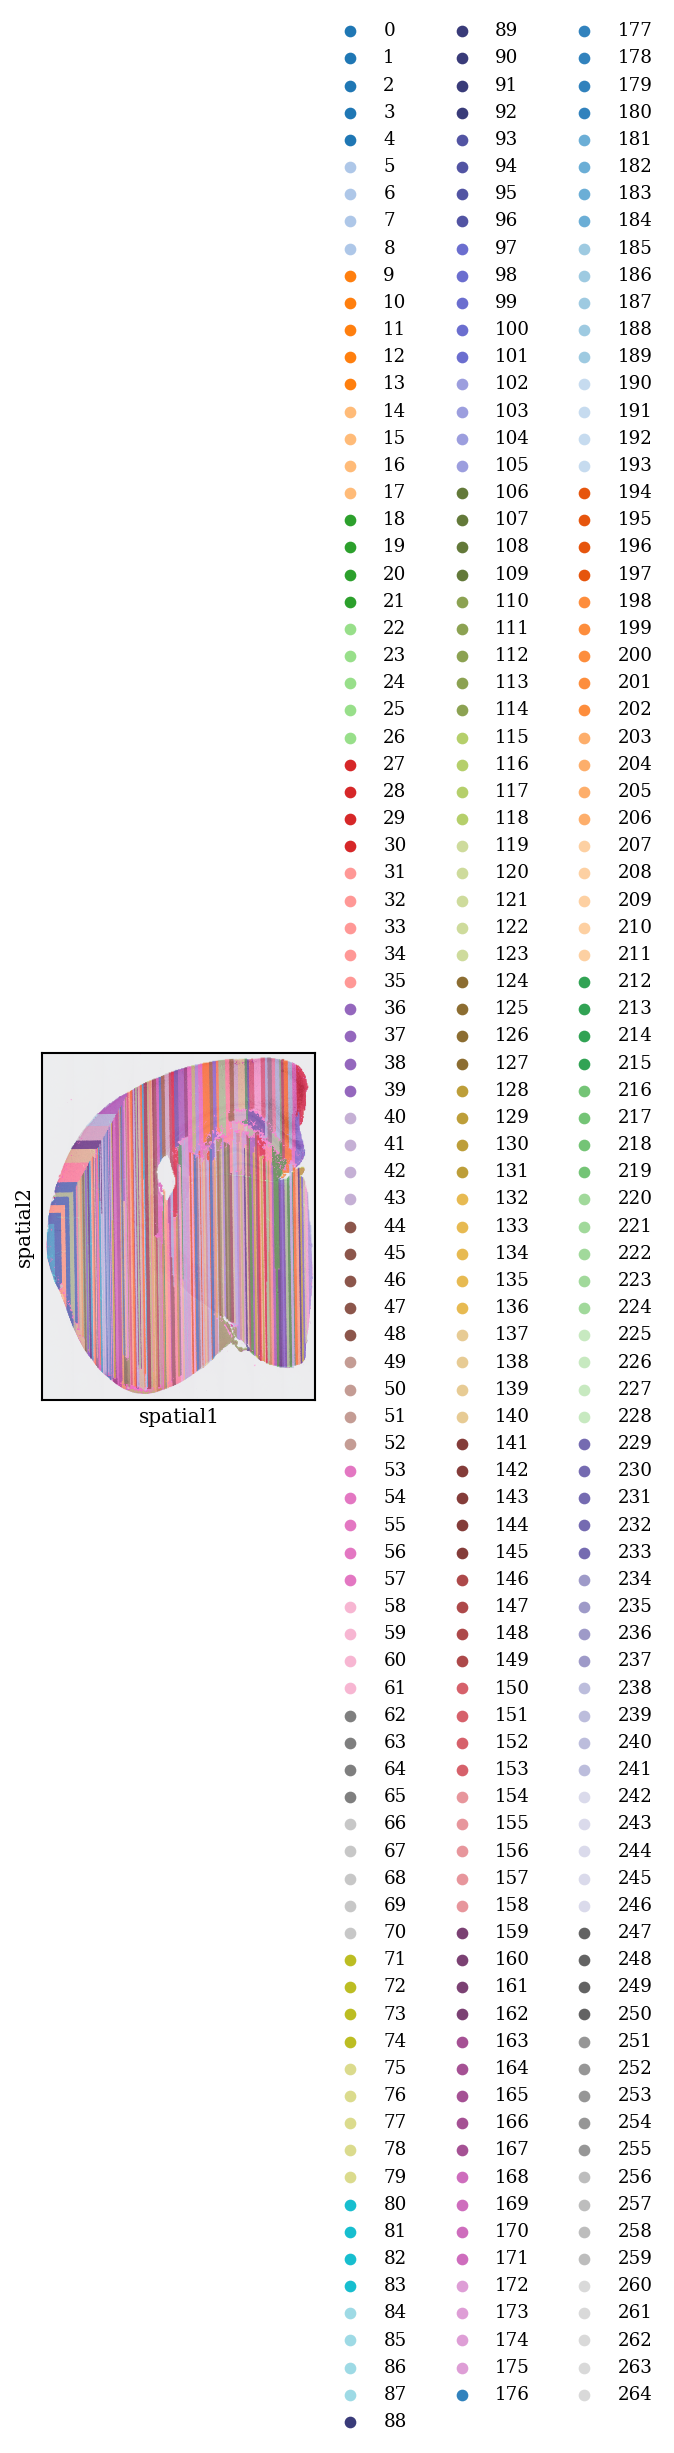

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sq.pl.spatial_scatter(andata016, color=f'clusters_spatial', ax=ax, palette=listed_cmap)
ax.set_title(f'')

In [24]:
andata016.obsm['spatial'] = np.array(andata016.obsm['spatial'], dtype=np.float64)

sq.gr.spatial_neighbors(andata016,coord_type="grid", n_neighs=6, n_rings=8, key_added='spatial_neighbors')
# Perform clustering using the spatial neighbors graph
sc.tl.leiden(andata016, key_added=f'clusters_spatial', adjacency=andata016.obsp['spatial_neighbors_connectivities'])

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sq.pl.spatial_scatter(andata016, color=f'clusters_spatial', ax=ax, palette=listed_cmap)
ax.set_title(f'')


KeyError: 'spatial_neighbors'

In [ ]:
def calcQCmat(andata):
    andata.var_names_make_unique()
    andata.var["mt"] = andata.var_names.str.startswith("mt-")
    andata.var["ribo"] = andata.var_names.str.startswith(("RPS", "RPL"))
    andata.var["hb"] = andata.var_names.str.contains("^HB[^(P)]")
    sc.pp.calculate_qc_metrics(andata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
    return andata
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_016um"
andata016_ = sc.read_visium(path=path_016)
andata016 = calcQCmat(andata016_)
print(f"{np.shape(andata016.X.todense())}")
sc.pp.filter_cells(andata016, min_counts = 50)
sc.pp.filter_cells(andata016, min_genes = 80)